# ML from scratch: Advanced reinforcement learning, Day 1

### Zach Cohen and John Vastola

<center><img src="https://github.com/john-vastola/AdvancedRL/blob/main/images/actor_critic_bad_cartoon.png?raw=true" alt="drawing" width="600"/></center>

**Welcome back to Machine Learning from Scratch!** For previous sessions, see the GitHub repository at: https://github.com/DrugowitschLab/ML-from-scratch-seminar

This week's session is on 'advanced' reinforcement learning (RL). In particular, given some challenging real-world task, what ingredients should we think about including in a RL model to make it (i) effective and (ii) stable?

We will focus on trying to understand the actor-critic architecture, and a specific algorithmic instantiation of it called [Advantage Actor Critic](https://arxiv.org/abs/1602.01783v2) (A2C). We will also touch on a few other RL model features that help with more challenging/realistic tasks.

Familiarity with RL, or with previous ML from scratch sessions, is not assumed. However, the two previous sessions on RL:

1. [Basic RL](https://github.com/DrugowitschLab/ML-from-scratch-seminar/tree/master/reinforcement%20learning)

2. [Deep RL](https://github.com/DrugowitschLab/ML-from-scratch-seminar/tree/master/DeepRL)

may be helpful if you're having trouble with the basic concepts.

**Credit attribution note**: A lot of code here is ripped directly from [this](https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/main/projects/ReinforcementLearning/lunar_lander.ipynb) notebook, which was part of a Neuromatch Academy session. The organization of the ideas was inspired by both of the previous ML from scratch sessions on RL, as well as Sutton and Barto's classic book.

---------------------------------------------------

## 0. Setup

When studying the basics of RL, you see two kinds of tasks over and over: (i) gridworld tasks, where an agent must take up-down-left-right steps on a 2D grid to get to a goal in as few steps as possible; and (ii) classical control tasks, like 'CartPole' and 'MountainCar'. This is because these tasks are simple, which allows one to focus on the fundamentals of RL rather than distracting task-specific details. So this makes sense.

But these tasks are also kind of boring, and we need to move beyond them to really understand why architectures like actor-critic are powerful. Our primary task for these two sessions will be provided by OpenAI Gym's [Lunar Lander](https://gym.openai.com/envs/LunarLanderContinuous-v2/) environment:




In [1]:
# @title Video-playing code
! git clone https://github.com/john-vastola/AdvancedRL
from IPython.display import HTML
from base64 import b64encode
 
def show_video_local(video_path, video_width = 600):
   
  video_file = open(video_path, "r+b").read()
 
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

Cloning into 'AdvancedRL'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 19 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


In [2]:
show_video_local('AdvancedRL/images/lunarlander_video.mp4')

You're trying to get the lunar lander to land, preferably in between the two yellow flags, as quickly and with as little fuel as possible. 

**Possible actions:**
* Do nothing
* Fire main engine with strength $\in [-1, 1]$
* Fire left/right engine with strength $\in [-1, 1]$

*Main engine.* Firing with strength $\in [-1,0)$: nothing happens. Firing at strength $0$ corresponds to firing at 50% power. Firing at strength $1$ corresponds to firing at 100% power. Firing between $0$ and $1$ corresponds to firing at an intermediate power level.

*Left/right engine.* Firing with strength $\in (-0.5, 0.5)$: nothing happens. Firing at strength $\leq -0.5$: left engine fires. Firing at strength $\geq 0.5$: right engine fires.

**Costs and rewards:**
*   -0.3 per frame when main engine is being fired
*   -0.03 per frame when left/right engine is being fired
* +10 for each leg-ground contact (lander has two legs)
* -100 for crashing, +100 for landing. Either ends the episode.
* Gain points at end of episode based on closeness to target between yellow flags.

**Target score:** 200+ points.

**State information (8 dimensions):**
* horizontal position
* vertical position
* horizontal velocity
* vertical velocity
* angle
* angular velocity
* left leg contact
* right leg contact

Don't worry about committing the above details to memory. This is just to spell out the goal of our RL agent. 

Lunar Lander and other RL environments---including classic control tasks like CartPole, and modern RL favorites like Atari games---are provided by [OpenAI Gym](https://gym.openai.com/). **OpenAI Gym takes care of the environments**, which define what we're trying to train an agent to succeed at; all *we* have to do is provide the code to train an agent. It also provides a standardized framework for creating your own RL environments.

Another useful set of tools is due to [Stable Baselines](https://stable-baselines.readthedocs.io/en/master/), which provides reference implementations of popular RL algorithms. In other words, **Stable Baselines provides a framework constructing and training RL agents**, so we don't have to start completely from scratch. 

Let's install both of them, and import other dependencies we will use, below.

In [1]:
# @title Install dependencies

!pip install rarfile --quiet
!pip install stable-baselines3 > /dev/null
!pip install box2d-py > /dev/null
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!sudo apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
import io
import os
import glob
import torch
import base64


import numpy as np
import matplotlib.pyplot as plt

import gym
from gym import spaces
from gym.wrappers import Monitor

import stable_baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env




print("Gym version:", gym.version.VERSION)


Gym version: 0.17.3


In [3]:
# @title More video-playing code
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

Just to check if everything works, try to run the following code.

In [9]:
# Make and initialize the environment
env = wrap_env(gym.make("LunarLanderContinuous-v2"))     # Make Lunar Lander environment
state = env.reset()                                      # Reset the environment



# Let agent with a uniform random policy play the game for one episode
total_reward = 0   

while True:
  env.render()                                           # used to render video frames
  
  action = env.action_space.sample()                     # choose a random action
  state, reward, done, info = env.step(action)           # perform your chosen action

  total_reward += reward                                 # increment total reward

  if done:                                               # if lander landed or crashed (i.e., if episode ended), end session
    break;


# Print total reward accumulated, and video of episode
print("Total reward:", total_reward, "(max = 200)")
env.close()
show_video()

Total reward: -240.80219487446678 (max = 200)


It should not be surprising that the above agent usually doesn't perform very well. For most tasks, randomly pressing buttons is not a good strategy. We will formalize the problem of doing better than randomly pressing buttons below.

-----------------------------------------------------

## 1. Basic reinforcement learning

The gist of RL is the following. An **agent** exists in an **environment**. The environment can be in different **states**, and generally changes state from one moment to the next. By taking **actions**, the agent can influence how the state of the environment changes. 

At each moment in time, the agent receives a **reward** depending on the state of the environment. By 'reward', we include both positive and negative things the agent cares about, so costs are included as negative rewards. The goal of the agent is to maximize total reward (or to achieve some morally similar goal, like maximizing temporally discounted reward, or reward *rate*). 

The basic loop of RL is visualized in Sutton and Barto's RL textbook via the following popular diagram:

![Everyone's favorite image from Sutton and Barto.](https://github.com/john-vastola/AdvancedRL/blob/main/images/sb_loop.png?raw=true)

In the case of the Lunar Lander environment:
* state = position and orientation of the lander
* actions = doing nothing or firing engines
* rewards = fuel costs and landing bonus/penalty

The environment controls how the lander moves. Gravity pulls it down, firing engines move it around, and it is also affected by collisions with the surface.


### Viewing basic information about the environment

OpenAI Gym gives us commands for viewing basic information about the environment. For example:

In [15]:
print(f'Action space: {env.action_space}')
print("Shape of action space:", env.action_space.shape)
print()

print(f'State/Observation space: {env.observation_space}')
print("Shape of state/observation space:", env.observation_space.shape)

#print("Action meanings:", env.unwrapped.get_action_meanings())               # This command actually doesn't work for our environment, but generally does for ones with discrete action spaces.

Action space: Box(-1.0, 1.0, (2,), float32)
Shape of action space: (2,)

State/Observation space: Box(-inf, inf, (8,), float32)
Shape of state/observation space: (8,)


`Box` is a common space representing real-valued possibilities, in this case between -1 and 1. `Discrete` is a common space where each action can be mapped to one nonnegative integer in a finite collection of such integers.

This matches what we wrote above. An action consists of two real numbers between $-1$ and $1$, which describe (i) how much to fire the main engine, and (ii) how much to fire the left/right engines.

The state of the lander is an 8-dimensional real number.

### Basic mathematical formulation of RL

Let us be more mathematically precise about states, actions, rewards, and what we mean by 'solving' an RL problem.

Spaces of interest:
* state space $\mathcal{S}$
* action space $\mathcal{A}(s)$ for each $s \in \mathcal{S}$
* reward space $\mathcal{R} \subset \mathbb{R}$

We assume that the agent interacts with the environment according to a Markov* decision process. The environment begins in a state $S_0 \in \mathcal{S}$, and the agent takes an action $A_0 \in \mathcal{A}(S_0)$. As a consequence of the action, the agent receives a reward $R_1 \in \mathcal{R}$ and the environment transitions to a state $S_1 \in \mathcal{S}$. This process continues:

$$S_0, A_0, R_1, S_1, A_1, R_2, S_2, A_2, R_3, ...$$

The environment changes according to a transition probability

$$p(s', r | s, a) := \text{Pr}\left\{ S_t = s', R_t = r | S_{t-1} = s, A_{t-1} = a \right\} \ .$$

In words, the above formula describes the following situation. The environment is in a state $s$ at time $t-1$. The agent then takes an action $a$. $p(s', r | s, a)$ tells us how often the environment transitions to a state $s'$ at time $t$, and how often the agent receives a reward $r$ after taking their action. 

How well an agent does is quantified by how much reward they get. Since in many situations, all else being equal, we prefer rewards now over rewards later, we often *discount* future rewards, treating them as less valuable. The reward accumulated from some time $t$ onward is:

$$G_t := R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \cdots = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1} \ , $$

where $\gamma \in [0, 1]$ is called the *discount rate*. The quantity $G_t$, called the **return**, is what the agent seeks to maximize over the course of an episode. 

In order to do this, the agent learns a **policy** $\pi(a | s)$, which determines the probability that they take action $a$ when the environment is in state $s$. The policy can be deterministic (such that the agent always takes the same action when in a given state), but it need not be in general.

Good policies are ones that maximize the expected return. The expected return from time $t$ onward, given that the environment starts in a state $s$ and the agent follows a policy $\pi$, is denoted

$$v_{\pi}(s) := \mathbb{E}[G_t | S_t = s] \ .$$

The function $v_{\pi}(s)$, called the **value function**, quantifies how good it is (in terms of expected future reward) to be in the state $s$. A related quantity is the **action-value function**

$$q_{\pi}(s, a) := \mathbb{E}[G_t | S_t = s, A_t = a] \ ,$$

which quantities the expected return from time $t$ onward, given that the environment starts in a state $s$ and the agent first takes an action $a$. We can denote estimates of these functions by $V_{\pi}(s)$ and $Q_{\pi}(s, a)$. When the agent takes the 'best' action it can in a given state $s$, it takes the action which maximizes $q_{\pi}(s, a)$. 

For a fairly broad class of environments, there always exists at least one policy $\pi_*$ for which the expected return is higher in all states than any other policy $\pi$, i.e.

$$v_{\pi_*}(s) \geq v_{\pi}(s) \text{ for all } s \in \mathcal{S} \text{ and policies } \pi \ .$$

Such policies are called **optimal**. In principle, the goal of our agent is to find them, or to at least learn a policy which becomes increasingly close to optimal over time.

### Learning good policies

The above is just formalism. How do we actually learn a policy $\pi$ which is 'good', in the sense of maximizing $v_{\pi}(s)$ for all $s \in \mathcal{S}$?

There are many possible approaches. One naive approach is to use something like an evolutionary algorithm: randomly generate many policies, let them do the task, keep and mutate the ones that do the best, and iterate. But such approaches can be extremely slow to converge, especially in state and action spaces that are large. They also do not exploit much of the rich structure associated with RL problems.  

The key insights of many RL algorithms are the following. (i) We can describe the goodness of a policy using a value function; and (ii) properties of the value function can be exploited to incrementally improve one's policy. From a dimensionality point of view, learning a value function is significantly easier than directly searching through policy space (we have to learn a scalar function of state space rather than an action-valued one). 

Perhaps the most important such properties are the Bellman equations for the optimal value function $v_*(s)$ and action-value function $q_*(s,a)$:

$$\begin{split}v_*(s) &= \max_a \mathbb{E}\left[ R_{t+1} + \gamma v_*(S_{t+1}) | S_{t} = s, A_t = a  \right] \\ &= \max_a \sum_{s', r'} p(s', r | s, a) \left[ r + \gamma v_*(s') \right]  \end{split}$$ 

$$\begin{split}q_*(s,a) &= \mathbb{E}\left[ R_{t+1} + \gamma \max_{a'} q_*(S_{t+1}, a') | S_t = s, A_t = a \right] \\ &= \sum_{s', r'} p(s', r | s, a) \left[ r + \gamma \max_{a'} q_*(s', a')  \right]       \end{split}$$

The idea behind using these equations for policy improvement is simple. We know that the left-hand side equals the right-hand side for the true value functions. For any non-optimal value functions, this is not true. **Given a value function for some non-optimal policy, keep taking differences between the left-hand side and right-hand side, in the hopes that one eventually recovers the optimal value function.** Maybe surprisingly, this works extremely well.



This is the idea, for example, behind the popular temporal-difference (TD) learning algorithms. For Sarsa, the simplest TD prediction method, one makes repeated updates:

$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[ RHS - LHS \right] = Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t) \right]$$

where $\alpha$ is a step-size parameter controlling the size of updates. Here's the boxed algorithm for Sarsa from Sutton and Barto: 

<center><img src="https://github.com/john-vastola/AdvancedRL/blob/main/images/tabular_sarsa_box.png?raw=true" alt="drawing" width="700"/></center>

Once you have $Q(s, a) \approx q_*(s, a)$, your near-optimal policy $\pi$ is determined. When in state $s \in \mathcal{S}$, you take the action $a \in \mathcal{A}$ for which $Q(s, a)$ is largest (with ties broken arbitrarily).

Of course, there are a great many variations and elaborations on this core idea that we will not go into here.

----------------------------------------------------------------------

## 2. Deep reinforcement learning

Above, we implicitly discussed what are known as **tabular** RL methods. The name comes from the fact that we assume we have a lookup table for value or action-value functions. The table for $Q(s,a)$ would have size $|\mathcal{S}|\times|\mathcal{A}|$. What happens when $|\mathcal{S}|$ and/or $|\mathcal{A}|$ are extremely large? This is the case for Atari games, for example, where a naive description of state involves the intensity of every pixel on the screen. Must we give up?

Fortunately, **approximate** methods offer an alternative to tabular methods. Instead of storing the values of $Q(s,a)$ for all $s$ and $a$, we construct a parameterized approximation $\hat{q}(s, a, \mathbf{w})$, where $\mathbf{w}$ are the parameters.

**Deep RL** involves specifically using deep neural networks as parameterized function approximators. In that context, the parameters $\mathbf{w}$ correspond to the weights of the network. 

In principle, this conceptually simple (but potentially theoretically complicated) difference allows us to handle much larger state and action spaces. Of course, for detailed approximations to the value or action-value functions (i.e., deep neural networks with many parameters), training can take a long time.

Learning good policies can proceed similarly to the tabular case. The main difference is that, because we are storing the parameter values $\mathbf{w}$ rather than the values $Q(s,a)$ directly, we need to incrementally update the former instead of the latter. 

The analogue to the simplest version of Sarsa involves weight updates

$$ \mathbf{w}_{t+1} = \mathbf{w}_t + \alpha \left[ R_{t+1} + \gamma \hat{q}(S_{t+1}, A_{t+1}, \mathbf{w}_t) - \hat{q}(S_t, A_t, \mathbf{w}_t) \right] \nabla \hat{q}(S_t, A_t, \mathbf{w}_t)$$

where $\alpha$ is again a step-size parameter. For deep RL, we have a closed form expression for $\nabla \hat{q}$; for other approaches, this term could be troublesome. The corresponding boxed algorithm from Sutton and Barto reads:

<center><img src="https://github.com/john-vastola/AdvancedRL/blob/main/images/approximate_sarsa_box.png?raw=true" alt="drawing" width="700"/></center>

These are the kinds of algorithms people are talking about when they talk about Deep Q-Networks (DQNs).

### DQN implementations in Stable Baselines

As mentioned above, [Stable Baselines](https://stable-baselines.readthedocs.io/en/master/) provides reference implementations of popular RL algorithms, including DQN-related ones. This is particularly helpful when it comes to DQNs, whose implementation details can be complicated; Stable Baselines can help us focus on the higher-level ideas.

Let's try a DQN on (a slightly simpler version of) the Lunar Lander task. In this version, the agent can't choose to fire its engines at different levels; it can only choose to fire them at a given moment in time, or not fire them.

In [4]:
nn_layers = [64,64] #This is the configuration of your neural network. Currently, we have two layers, each consisting of 64 neurons.
                    #If you want three layers with 64 neurons each, set the value to [64,64,64] and so on.

learning_rate = 0.001 #This is the step-size with which the gradient descent is carried out.
                      #Tip: Use smaller step-sizes for larger networks.

In [5]:
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env = gym.make('LunarLander-v2')
#You can also load other environments like cartpole, MountainCar, Acrobot. Refer to https://gym.openai.com/docs/ for descriptions.
#For example, if you would like to load Cartpole, just replace the above statement with "env = gym.make('CartPole-v1')".

env = stable_baselines3.common.monitor.Monitor(env, log_dir )

callback = EvalCallback(env,log_path = log_dir, deterministic=True) #For evaluating the performance of the agent periodically and logging the results.
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=nn_layers)
model = DQN("MlpPolicy", env,policy_kwargs = policy_kwargs,
            learning_rate=learning_rate,
            batch_size=1,  #for simplicity, we are not doing batch update.
            buffer_size=1, #size of experience of replay buffer. Set to 1 as batch update is not done
            learning_starts=1, #learning starts immediately!
            gamma=0.99, #discount facto. range is between 0 and 1.
            tau = 1,  #the soft update coefficient for updating the target network
            target_update_interval=1, #update the target network immediately.
            train_freq=(1,"step"), #train the network at every step.
            max_grad_norm = 10, #the maximum value for the gradient clipping
            exploration_initial_eps = 1, #initial value of random action probability
            exploration_fraction = 0.5, #fraction of entire training period over which the exploration rate is reduced
            gradient_steps = 1, #number of gradient steps
            seed = 1, #seed for the pseudo random generators
            verbose=0) #Set verbose to 1 to observe training logs. We encourage you to set the verbose to 1.

# You can also experiment with other RL algorithms like A2C, PPO, DDPG etc. Refer to  https://stable-baselines3.readthedocs.io/en/master/guide/examples.html
#for documentation. For example, if you would like to run DDPG, just replace "DQN" above with "DDPG".

Here's a video of how it does before training:

In [6]:
test_env = wrap_env(gym.make("LunarLander-v2"))
observation = test_env.reset()
total_reward = 0
while True:
  test_env.render()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action)
  total_reward += reward
  if done:
    break;

# print(total_reward)
test_env.close()
show_video()

Train it...

In [7]:
model.learn(total_timesteps=100000, log_interval=10, callback=callback)
# The performance of the training will be printed every 10 episodes. Change it to 1, if you wish to
# view the performance at every training episode.

Eval num_timesteps=10000, episode_reward=-844.94 +/- 370.24
Episode length: 123.60 +/- 33.29
New best mean reward!
Eval num_timesteps=20000, episode_reward=-344.31 +/- 45.73
Episode length: 164.60 +/- 48.43
New best mean reward!
Eval num_timesteps=30000, episode_reward=-339.86 +/- 45.03
Episode length: 459.40 +/- 84.61
New best mean reward!
Eval num_timesteps=40000, episode_reward=-30.48 +/- 25.62
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=50000, episode_reward=140.99 +/- 104.92
Episode length: 187.00 +/- 90.95
New best mean reward!
Eval num_timesteps=60000, episode_reward=-45.50 +/- 19.66
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=23.22 +/- 121.02
Episode length: 317.80 +/- 88.52
Eval num_timesteps=80000, episode_reward=-11.67 +/- 21.72
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=110.11 +/- 88.98
Episode length: 595.60 +/- 277.44
Eval num_timesteps=100000, episode_reward=63.41 +/- 130.02
Episod

Now here's its performance after training:

In [9]:
env = wrap_env(gym.make("LunarLander-v2"))
observation = env.reset()
while True:
  env.render()
  action, _states = model.predict(observation, deterministic=True)
  observation, reward, done, info = env.step(action)
  if done:
    break;

env.close()
show_video()

To see how quickly and stably our agent learned, we can take a look at its learning curve: reward versus the number of time steps experienced so far.

Text(0, 0.5, 'Episode Rewards')

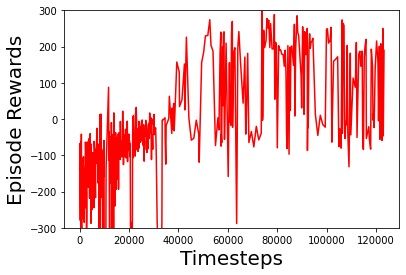

In [11]:
x, y = ts2xy(load_results(log_dir), 'timesteps')  # Organising the logged results in to a clean format for plotting.
plt.plot(x,y, color='red')
plt.ylim([-300, 300])
plt.xlabel('Timesteps',fontsize=20)
plt.ylabel('Episode Rewards',fontsize=20)

------------------------------------------------------------

## 3. Problems with RL / making things work in practice

DQNs are not perfect. If you trained a simple DQN on the simplified Lunar Lander task above, you may have noticed that the learning curve is extremely noisy. Stability is a serious problem for DQNs, and a lack of stability can lead to common issues like 'catastrophic forgetting': a reasonably well-performing agent adjusts its policy during learning so that its performance suddenly and drastically declines, sometimes in a way that is hard to recover from without some kind of backup.

And this is just one problem out of many that RL algorithms must contend with in practice. Common challenges include:
* Large state/action spaces
* Balancing exploration and exploitation
* Credit assignment over long time horizons (which actions were ultimately most responsible for a good final result?)

The fundamentals of RL have not significantly changed since the 90s; the core ideas from the previous sections still work. But there is a whole galaxy of RL research and engineering, which is sometimes more of an art than a science, whose aim is to add extra ingredients to these basic ideas so that the resulting algorithms are more stable, and can better handle some of the above challenges.

To get a sense of this, consider the following illustration discussing the ingredients that went into DeepMind's "[Agent57](https://deepmind.com/blog/article/Agent57-Outperforming-the-human-Atari-benchmark)", an RL agent that achieves superhuman performance on the 57 Atari game benchmark:

<center><img src="https://github.com/john-vastola/AdvancedRL/blob/main/images/deepmind_improvements.png?raw=true" alt="drawing" width="600"/></center>


On the one hand, it may be surprising that so much art and so many little improvements appear to be necessary for superhuman performance. On the other hand, perhaps not; RL is an incredibly broad field that is, in essence, about *how to learn to be good at anything*. 

Our brains are examples of extremely complex RL agents navigating highly uncertain environments. If there was a simple solution to all RL problems, our brains would probably be much simpler.

One important advance beyond vanilla DQNs is the idea of **actor-critic architectures**. This is one family of algorithms that we will discuss in detail, and that you will get a chance to (partially) implement in the following session.

-------------------------------------------------------------------------

## 4. Concepts behind actor-critic

Our first notion of the actor-critic idea might come from the following observation. We care about both *policies* and *value functions*, and in principle *we can construct parameterized approximations of both*.

Just like the approach of DQNs approximates action-value functions via $\hat{q}(s, a, \mathbf{w})$, we can also imagine approximating policies via $\hat{\pi}(a | s, \boldsymbol{\theta})$, where $\boldsymbol{\theta}$ is some set of parameters. In the following, we will specifically imagine $\hat{\pi}$ to come from a deep neural network, so that the parameters $\boldsymbol{\theta}$ correspond to the weights of that network, but this need not be the case in general.




### Why actor-critic?


Why should we do something like this? There are a few reasons. One reason is that, just as using approximate value functions allows us to more easily deal with large *state* spaces, approximating policies allows us to more easily deal with large *action* spaces. This is not an issue that comes up for Atari games, but it *is* one that comes up for continuous control tasks (and in neuroscience...ask us about catching fireflies), where the number of possible actions is technically infinite. 

Another reason is stability. It can happen that, given arbitrarily small changes in an agent's action-value function $\hat{q}$, the resulting policy can change substantially (for example, because the action $a$ for which $\hat{q}(s, a, \mathbf{w})$ is largest changes discontinuously). If the policy $\hat{\pi}$ is parameterized by weights $\boldsymbol{\theta}$, updating $\boldsymbol{\theta}$ should lead to smooth changes in policy.

Unlike vanilla DQNs, actor-critic methods can learn an explicitly stochastic policy, which can be helpful for avoiding annoying hyperparameter tuning (e.g., in the case of $\epsilon$-greedy action selection), and for succeeding in tasks involving uncertain information (like Poker).

Finally, adopting the idea of an actor-critic architecture allows us to make other generalizations that help address various problems (e.g., with stability).

### Basic actor-critic architecture

So we've decided to approximate the action-value function $q$, and the policy $\pi$, using deep neural networks. We can picture one entity updating the action-value function---this is the titular **critic**---and another entity that updates the policy, the **actor**. 

The actor uses its policy to take an action. In response, the critic updates its assessment of the actor, and offers feedback on whether that action was good or bad. Finally, the actor adjusts its performance in response to that feedback, and the cycle continues. 

<center><img src="https://github.com/john-vastola/AdvancedRL/blob/main/images/actor_critic_bad_cartoon.png?raw=true" alt="drawing" width="600"/></center>

The architecture can be visualized as follows:

<center><img src="https://github.com/john-vastola/AdvancedRL/blob/main/images/actor_critic.png?raw=true" alt="drawing" width="400"/></center>

The "TD error" in the above diagram refers to the RHS - LHS difference from TD prediction algorithms like Sarsa (although here, since $v$ rather than $q$ is used, it is slightly different than what we wrote above).

The specific updates for this entirely online RL algorithm are the following. 

**Want to learn**: 
* parameterized value function $\hat{v}(s, \mathbf{w})$
* parameterized policy $\hat{\pi}(a | s, \boldsymbol{\theta})$

**TD error controlling update sizes**:
$$\delta_t := R_{t+1} + \gamma \hat{v}(S_{t+1}, \mathbf{w}_t) - \hat{v}(S_t, \mathbf{w}_t)$$

**Value function parameter update**:
$$\mathbf{w}_{t+1} = \mathbf{w}_t + \alpha_1 \left[ R_{t+1} + \gamma \hat{v}(S_{t+1}, \mathbf{w}_t) - \hat{v}(S_t, \mathbf{w}_t) \right] \nabla \hat{v}(S_t, \mathbf{w}_t) = \mathbf{w}_t + \alpha_1 \delta_t \nabla \hat{v}(S_t, \mathbf{w}_t) $$

**Policy parameter update**:
$$\boldsymbol{\theta}_{t+1} = \boldsymbol{\theta}_t + \alpha_2 \left[ R_{t+1} + \gamma \hat{v}(S_{t+1}, \mathbf{w}_t) - \hat{v}(S_t, \mathbf{w}_t) \right] \frac{\nabla \hat{\pi}(A_t | S_t, \boldsymbol{\theta}_t)}{\hat{\pi}(A_t | S_t, \boldsymbol{\theta}_t)} = \boldsymbol{\theta}_t + \alpha_2 \delta_t \frac{\nabla \hat{\pi}(A_t | S_t, \boldsymbol{\theta}_t)}{\hat{\pi}(A_t | S_t, \boldsymbol{\theta}_t)}$$

In practice, although we denote the parameters of the value function ($\mathbf{w}$) and policy ($\boldsymbol{\theta}$) as entirely separate, we often use a single deep neural network with both functions as outputs, so that many parameters are shared.

Here's the boxed algorithm from Sutton and Barto:

<center><img src="https://github.com/john-vastola/AdvancedRL/blob/main/images/actor_critic_box.png?raw=true" alt="drawing" width="700"/></center>


Where do the parameter updates come from? The critic parameter update comes from trying to improve the weights $\mathbf{w}_t$ by minimizing an objective function

$$J_1(\mathbf{w}_t) = \left[ G_t - \hat{v}(S_t, \mathbf{w}_t) \right]^2$$

where $G_t := R_{t+1} + \gamma \hat{v}(S_{t+1}, \mathbf{w}_{t})$ is an estimate of the return at time $t$. In particular, $\mathbf{w}_{t+1}$ comes from estimating the gradient (with respect to $\mathbf{w}_t)$ of the above.

The actor parameter update comes from trying to improve the weights $\boldsymbol{\theta}_t$ by minimizing an objective function

$$J_2(\boldsymbol{\theta}_t) = \hat{v}_{\pi_{\boldsymbol{\theta}}}(S_t, \mathbf{w}_t) \ ,$$

where we have used a subscript on $\hat{v}$ to indicate that our value function estimates depend on $\boldsymbol{\theta}_t$ through their dependence on $\hat{\pi}$. In particular, $\boldsymbol{\theta}_{t+1}$ comes from estimating the gradient (with respect to $\boldsymbol{\theta}_t$) of the above. It can be shown that

$$ \nabla_{\boldsymbol{\theta}} J_2(\boldsymbol{\theta}_t) \propto \mathbb{E}_{\pi}\left[ G_t \frac{\nabla_{\boldsymbol{\theta}}  \hat{\pi}(A_t | S_t, \boldsymbol{\theta}_t)}{\hat{\pi}(A_t | S_t, \boldsymbol{\theta}_t)}  \right] \ . $$



### Advantage actor-critic (A2C)

[Advantage actor-critic](https://arxiv.org/abs/1602.01783v2), or A2C, is a simple but powerful elaboration on the actor-critic idea. It is almost the same as the above, but with a slight tweak to improve the variance of the gradient estimates that appear in the parameter updates. 

The change is to write:

$$ \nabla_{\boldsymbol{\theta}} J_2(\boldsymbol{\theta}_t) \propto \mathbb{E}_{\pi}\left[ \left( G_t - b(S_t) \right) \frac{\nabla_{\boldsymbol{\theta}}  \hat{\pi}(A_t | S_t, \boldsymbol{\theta}_t)}{\hat{\pi}(A_t | S_t, \boldsymbol{\theta}_t)}  \right] $$

where $b(S_t)$ is some possibly state-dependent arbitrary baseline. In expectation, the contribution of this term is zero (which is why we can decide to include it), but it can be chosen to reduce the variance of these gradients. The choice A2C uses is $b(S_t) = \hat{v}(S_t, \mathbf{w}_t)$, which can be theoretically motivated.

One can make other small changes to the basic actor-critic algorithm, like using $n$-step returns instead of one-step returns. This means updating the parameters every $n$ time steps (using a suitably modified TD error $\delta_t$) instead of every individual time step.

Another helpful change is to use multiple actors that update their parameters at different times. This helps explore different parts of state space in an uncorrelated way (and hence goes some of the way in addressing the exploration versus exploitation dilemma).

**Next session**: Implementing A2C!